In [1]:
# importing libraries
import pandas as pd 
import pickle
import numpy as np
import re
from tqdm import tqdm

import nltk
from nltk import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("airline_sentiment_analysis.csv", encoding="latin-1")
df.head()

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [3]:
X = df["text"]
X.head()
print(X.shape)

(11541,)


In [4]:
y = df["airline_sentiment"].map({"positive":1, "negative":0})
y.head()

0    1
1    0
2    0
3    0
4    1
Name: airline_sentiment, dtype: int64

In [5]:
def decontracted(phrase):
    """
    """
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [6]:
# by refering to this github link https://gist.github.com/sebleier/554280
# we are removing the words from the stopwords list like: 'no', 'nor', 'not' 
# from nltk.corpus import stopwords
# print (stopwords.words('english'))

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

len(stopwords)
lemmatizer = WordNetLemmatizer()

In [7]:
def print_10(lists):
    for i in range(10):
        print(lists[i], "\n")

In [8]:
def text_preprocessing(text):
    """
    """
    text = text.lower()
    text = re.sub(r"http\S+", "", text) # removing any links in the text
    text = re.sub(r"@\S+", "", text) # we need to remove all username as it dosen't contribute to SA 
    text = text.replace("#", "") # removing hash but keeping text #fabulous => fabulous    
    text = decontracted(text) 
    text = re.sub("\S*\d\S*", "", text).strip() # remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove spacial character: https://stackoverflow.com/a/5843547/4084039
    text = ' '.join(e for e in text.split() if e not in stopwords) # using own created stopwords 
    # removing any words which have less than 3 character and lemmatizer those words having higher than 2 character
    text = ' '.join(lemmatizer.lemmatize(e) for e in text.split() if len(e) > 2) 
        
    return text


In [9]:
preprocessed_X = []
for text in tqdm(X.values):
    preprocessed_X.append( text_preprocessing(text) )
    
print_10(preprocessed_X)


100%|██████████████████████████████████████████████████████████████████████████| 11541/11541 [00:02<00:00, 5131.67it/s]

plus added commercial experience tacky 

really aggressive blast obnoxious entertainment guest face amp little recourse 

really big bad thing 

seriously would pay flight seat not playing really bad thing flying 

yes nearly every time fly ear worm away 

well not 

amazing arrived hour early good 

pretty graphic much better minimal iconography 

great deal already thinking trip amp not even gone trip yet 

flying fabulous seductive sky take stress away travel 



In [10]:
list_of_words=[]
for words in tqdm(preprocessed_X):
    list_of_words.append(words.split())
    

100%|████████████████████████████████████████████████████████████████████████| 11541/11541 [00:00<00:00, 804414.76it/s]


In [11]:
print_10(list_of_words)

['plus', 'added', 'commercial', 'experience', 'tacky'] 

['really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guest', 'face', 'amp', 'little', 'recourse'] 

['really', 'big', 'bad', 'thing'] 

['seriously', 'would', 'pay', 'flight', 'seat', 'not', 'playing', 'really', 'bad', 'thing', 'flying'] 

['yes', 'nearly', 'every', 'time', 'fly', 'ear', 'worm', 'away'] 

['well', 'not'] 

['amazing', 'arrived', 'hour', 'early', 'good'] 

['pretty', 'graphic', 'much', 'better', 'minimal', 'iconography'] 

['great', 'deal', 'already', 'thinking', 'trip', 'amp', 'not', 'even', 'gone', 'trip', 'yet'] 

['flying', 'fabulous', 'seductive', 'sky', 'take', 'stress', 'away', 'travel'] 



In [12]:
# min_count = 5 considers only words that occured atleast 5 times and size=50 as we have small dataset and i want to keep smaller dimension
w2v_model = Word2Vec(size=50, min_count=5, workers=4)
w2v_model.build_vocab(list_of_words)

In [13]:
total_corpus = w2v_model.corpus_count
print(total_corpus)

11541


In [14]:
w2v_model.train(list_of_words, total_examples=total_corpus, epochs=w2v_model.iter) 

<ipython-input-14-4a7a47f594af>:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  w2v_model.train(list_of_words, total_examples=total_corpus, epochs=w2v_model.iter)


(392446, 520305)

In [15]:
# Save the w2v model
w2v_model.save('w2vmodel')
# Load the w2v model
new_w2v_model = gensim.models.Word2Vec.load('w2vmodel')

In [16]:
print(new_w2v_model["great"].shape)
print('='*100,"\n")
print(new_w2v_model["great"])
print('='*100, "\n")
print(new_w2v_model.most_similar("great"))
print('='*100, "\n")

(50,)

[-0.00792831  0.08594432  0.00706647  0.32977265  0.40310773  1.1402475
  0.12192062 -0.37139836  0.2056133   0.08016017  0.01239201  0.9805554
 -0.7341073  -0.6557884  -0.45287797  0.10568689  0.07755177 -0.00469122
 -0.11535216  0.2562798  -0.31044713  0.18143858 -0.12209068  0.18925498
  0.01808091 -0.315106   -0.29021916  0.4664074  -0.18621045  0.01895311
  0.02997638 -0.62632537 -0.5381376  -0.06070141 -0.43747312  0.14601158
  0.2833449  -0.31920508 -0.38978255  0.02233131  0.49345294 -0.73430645
  0.02713894  0.5560155   0.21398927  0.56025845  0.53205675  0.5178734
  0.44109225  0.39053148]

[('guy', 0.9986984729766846), ('best', 0.9986656904220581), ('care', 0.9986512064933777), ('thank', 0.9985325336456299), ('terrible', 0.998488187789917), ('horrible', 0.9984557628631592), ('poor', 0.9983687996864319), ('excellent', 0.9983378648757935), ('fly', 0.9979518055915833), ('amazing', 0.9978809952735901)]



<ipython-input-16-88acc86b8f0e>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(new_w2v_model["great"].shape)
<ipython-input-16-88acc86b8f0e>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(new_w2v_model["great"])
<ipython-input-16-88acc86b8f0e>:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  print(new_w2v_model.most_similar("great"))


In [17]:
def createWordVector(each_text, size=50):
    """
    """
    vec = np.zeros(size).reshape(size)
    count = 0.
    for word in each_text:
        try:
            vec += new_w2v_model[word].reshape(size)
            count += 1.
            
        except KeyError: # handling the case where the each_text is not
                         # in the corpus. useful for testing.
            continue
    if count != 0: 
        vec /= count
        
    return vec

In [18]:
#Splitting for training and testing
x_train, x_test, y_train, y_test = train_test_split(np.array(list_of_words), np.array(y), test_size=0.3)


In [19]:
len(x_train)

8078

In [20]:
x_train_v2w = list(map(createWordVector, x_train))

<ipython-input-17-14983b8106c4>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += new_w2v_model[word].reshape(size)


In [21]:
x_test_v2w = list(map(createWordVector, x_test))

<ipython-input-17-14983b8106c4>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += new_w2v_model[word].reshape(size)


In [22]:
print(len(x_train_v2w))

8078


In [23]:
x_train_v2w = np.array(x_train_v2w)
x_test_v2w = np.array(x_test_v2w)

In [24]:
x_train_v2w.shape

(8078, 50)

In [25]:
x_test_v2w.shape

(3463, 50)

In [26]:
assert(x_train_v2w.shape[0] == y_train.shape[0]), "The number of train_text is not equal to the number of labels."
assert(x_train_v2w.shape[1] == (50)), "The dimensions of the train_text(w2v) are not 50"
assert(x_test_v2w.shape[0] == y_test.shape[0]), "The number of test text is not equal to the number of labels."
assert(x_test_v2w.shape[1] == (50)), "The dimensions of the test text(w2v) are not 50"


## LogisticRegression Model

In [28]:
from sklearn import linear_model

In [29]:
reg = linear_model.LogisticRegression(solver='lbfgs')
reg.fit(x_train_v2w, y_train)

LogisticRegression()

In [30]:
reg.score(x_train_v2w, y_train)

0.8201287447387967

In [31]:
reg.score(x_test_v2w, y_test)

0.8166329771874098

## SVM Model

In [32]:
from sklearn.svm import SVC as svmc

In [98]:
svm = svmc(kernel='linear', C=1.0)
svm.fit(x_train_v2w, y_train)

SVC(kernel='linear')

In [99]:
y_pred = svm.predict(x_test_v2w)

In [100]:
from sklearn import metrics

In [101]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8172105111175282


In [102]:
svm.score(x_train_v2w, y_train)

0.8172815053230997

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
randClf = RandomForestClassifier(n_estimators=4000, max_depth=20, max_features="log2", min_samples_leaf=3, random_state=0)


In [93]:
randClf.fit(x_train_v2w, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=3,
                       n_estimators=4000, random_state=0)

In [94]:
randClf.score(x_train_v2w, y_train)

0.9659569200297103

In [95]:
y_pred = randClf.predict(x_test_v2w)

In [96]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8504187120993358


In [97]:
randClf.score(x_test_v2w, y_test)

0.8504187120993358

## Gaussian Naive Bayes model

In [81]:
from sklearn.naive_bayes import GaussianNB

In [83]:
NBModel = GaussianNB()

In [84]:
NBModel.fit(x_train_v2w, y_train)

GaussianNB()

In [85]:
NBModel.score(x_train_v2w, y_train)

0.6666254023273087

In [86]:
NBModel.score(x_test_v2w, y_test)

0.6503032053133122

In [111]:
x_train_v2w.shape

(8078, 50)

## Dense Network Model1 - Adam()

In [112]:
def model1():
    model = Sequential()
    model.add(Dense(40, activation='relu', input_dim=50))
    model.add(Dropout(0.4))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(Adam(lr = 0.001), loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model


In [113]:
model1 = model1()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 40)                2040      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 3,037
Trainable params: 3,037
Non-trainable params: 0
____________________________________________________

In [114]:
history = model1.fit(x_train_v2w, y_train, validation_split = 0.2, epochs=100, batch_size=64, verbose=2, shuffle=1)

Epoch 1/100
101/101 - 0s - loss: 0.5563 - accuracy: 0.7649 - val_loss: 0.5212 - val_accuracy: 0.7877
Epoch 2/100
101/101 - 0s - loss: 0.5136 - accuracy: 0.7956 - val_loss: 0.5018 - val_accuracy: 0.7877
Epoch 3/100
101/101 - 0s - loss: 0.4976 - accuracy: 0.7956 - val_loss: 0.4919 - val_accuracy: 0.7877
Epoch 4/100
101/101 - 0s - loss: 0.4862 - accuracy: 0.7956 - val_loss: 0.4784 - val_accuracy: 0.7877
Epoch 5/100
101/101 - 0s - loss: 0.4763 - accuracy: 0.7956 - val_loss: 0.4720 - val_accuracy: 0.7877
Epoch 6/100
101/101 - 0s - loss: 0.4718 - accuracy: 0.7956 - val_loss: 0.4655 - val_accuracy: 0.7877
Epoch 7/100
101/101 - 0s - loss: 0.4664 - accuracy: 0.7956 - val_loss: 0.4633 - val_accuracy: 0.7877
Epoch 8/100
101/101 - 0s - loss: 0.4661 - accuracy: 0.7956 - val_loss: 0.4599 - val_accuracy: 0.7877
Epoch 9/100
101/101 - 0s - loss: 0.4649 - accuracy: 0.7956 - val_loss: 0.4618 - val_accuracy: 0.7877
Epoch 10/100
101/101 - 0s - loss: 0.4646 - accuracy: 0.7956 - val_loss: 0.4601 - val_accura

Epoch 82/100
101/101 - 0s - loss: 0.3878 - accuracy: 0.8333 - val_loss: 0.3588 - val_accuracy: 0.8540
Epoch 83/100
101/101 - 0s - loss: 0.3841 - accuracy: 0.8357 - val_loss: 0.3556 - val_accuracy: 0.8558
Epoch 84/100
101/101 - 0s - loss: 0.3810 - accuracy: 0.8366 - val_loss: 0.3628 - val_accuracy: 0.8515
Epoch 85/100
101/101 - 0s - loss: 0.3778 - accuracy: 0.8432 - val_loss: 0.3575 - val_accuracy: 0.8601
Epoch 86/100
101/101 - 0s - loss: 0.3925 - accuracy: 0.8318 - val_loss: 0.3643 - val_accuracy: 0.8441
Epoch 87/100
101/101 - 0s - loss: 0.3851 - accuracy: 0.8346 - val_loss: 0.3542 - val_accuracy: 0.8533
Epoch 88/100
101/101 - 0s - loss: 0.3809 - accuracy: 0.8347 - val_loss: 0.3570 - val_accuracy: 0.8608
Epoch 89/100
101/101 - 0s - loss: 0.3805 - accuracy: 0.8403 - val_loss: 0.3559 - val_accuracy: 0.8552
Epoch 90/100
101/101 - 0s - loss: 0.3822 - accuracy: 0.8377 - val_loss: 0.3577 - val_accuracy: 0.8546
Epoch 91/100
101/101 - 0s - loss: 0.3775 - accuracy: 0.8384 - val_loss: 0.3492 - v

Text(0.5, 0, 'epoch')

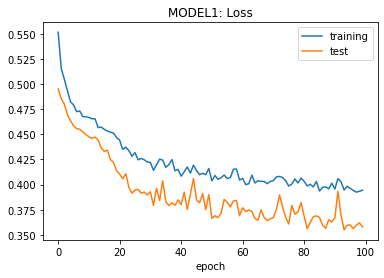

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','test'])
plt.title('MODEL1: Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

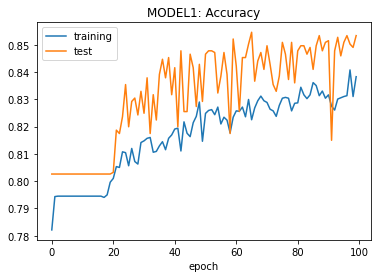

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('MODEL1: Accuracy')
plt.xlabel('epoch')

In [36]:
score = model1.evaluate(x_test_v2w, y_test, verbose=0)

In [37]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.36829447746276855
Test accuracy: 0.8495523929595947


In [38]:
#saving model
model1.save("model1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model1\assets


## Model 2 - RMSprop()

In [39]:
def model2():
    model = Sequential()
    model.add(Dense(40, activation='relu', input_dim=50))
    model.add(Dropout(0.4))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(RMSprop(lr = 0.01), loss='mse', metrics=['accuracy'])
    print(model.summary())
    return model

In [40]:
model2 = model2()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 40)                2040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,037
Trainable params: 3,037
Non-trainable params: 0
____________________________________________________

In [41]:
history2 = model2.fit(x_train_v2w, y_train, validation_split = 0.2, epochs=100, batch_size=64, verbose=2, shuffle = 1)

Epoch 1/100
101/101 - 0s - loss: 0.1645 - accuracy: 0.7942 - val_loss: 0.1509 - val_accuracy: 0.8026
Epoch 2/100
101/101 - 0s - loss: 0.1565 - accuracy: 0.7945 - val_loss: 0.1477 - val_accuracy: 0.8026
Epoch 3/100
101/101 - 0s - loss: 0.1545 - accuracy: 0.7945 - val_loss: 0.1475 - val_accuracy: 0.8026
Epoch 4/100
101/101 - 0s - loss: 0.1539 - accuracy: 0.7945 - val_loss: 0.1501 - val_accuracy: 0.8026
Epoch 5/100
101/101 - 0s - loss: 0.1514 - accuracy: 0.7945 - val_loss: 0.1466 - val_accuracy: 0.8026
Epoch 6/100
101/101 - 0s - loss: 0.1524 - accuracy: 0.7945 - val_loss: 0.1443 - val_accuracy: 0.8026
Epoch 7/100
101/101 - 0s - loss: 0.1521 - accuracy: 0.7945 - val_loss: 0.1456 - val_accuracy: 0.8026
Epoch 8/100
101/101 - 0s - loss: 0.1513 - accuracy: 0.7945 - val_loss: 0.1475 - val_accuracy: 0.8026
Epoch 9/100
101/101 - 0s - loss: 0.1507 - accuracy: 0.7945 - val_loss: 0.1420 - val_accuracy: 0.8026
Epoch 10/100
101/101 - 0s - loss: 0.1501 - accuracy: 0.7945 - val_loss: 0.1419 - val_accura

Epoch 82/100
101/101 - 0s - loss: 0.1336 - accuracy: 0.8231 - val_loss: 0.1188 - val_accuracy: 0.8459
Epoch 83/100
101/101 - 0s - loss: 0.1314 - accuracy: 0.8245 - val_loss: 0.1191 - val_accuracy: 0.8434
Epoch 84/100
101/101 - 0s - loss: 0.1312 - accuracy: 0.8251 - val_loss: 0.1178 - val_accuracy: 0.8465
Epoch 85/100
101/101 - 0s - loss: 0.1315 - accuracy: 0.8305 - val_loss: 0.1217 - val_accuracy: 0.8434
Epoch 86/100
101/101 - 0s - loss: 0.1314 - accuracy: 0.8258 - val_loss: 0.1214 - val_accuracy: 0.8472
Epoch 87/100
101/101 - 0s - loss: 0.1296 - accuracy: 0.8251 - val_loss: 0.1373 - val_accuracy: 0.8261
Epoch 88/100
101/101 - 0s - loss: 0.1288 - accuracy: 0.8312 - val_loss: 0.1421 - val_accuracy: 0.8193
Epoch 89/100
101/101 - 0s - loss: 0.1300 - accuracy: 0.8264 - val_loss: 0.1275 - val_accuracy: 0.8342
Epoch 90/100
101/101 - 0s - loss: 0.1299 - accuracy: 0.8254 - val_loss: 0.1216 - val_accuracy: 0.8410
Epoch 91/100
101/101 - 0s - loss: 0.1306 - accuracy: 0.8251 - val_loss: 0.1175 - v

Text(0.5, 0, 'epoch')

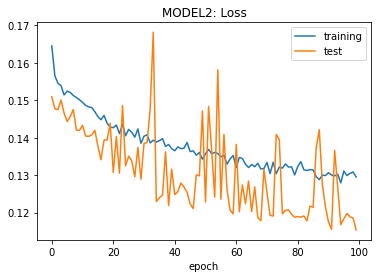

In [42]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training','test'])
plt.title('MODEL2: Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

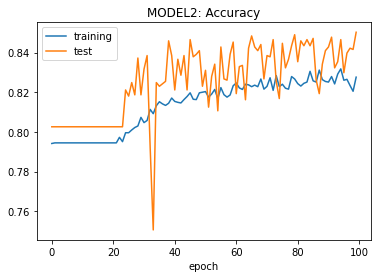

In [43]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('MODEL2: Accuracy')
plt.xlabel('epoch')

In [44]:
score2 = model2.evaluate(x_test_v2w, y_test, verbose=1)

109/109 [==============================] - 0s 540us/step - loss: 0.1176 - accuracy: 0.8429


In [45]:
print('Test score:', score2[0])
print('Test accuracy:', score2[1])

Test score: 0.11762043833732605
Test accuracy: 0.8429107666015625


In [46]:
#to save model
model2.save("model2")


INFO:tensorflow:Assets written to: model2\assets


In [65]:

#to load model https://www.tensorflow.org/guide/keras/save_and_serialize
reconstructed_model = keras.models.load_model(r"tashi/model2")